In [1]:
import numpy as np
from rlbench.action_modes.action_mode import MoveArmThenGripper
from rlbench.action_modes.arm_action_modes import ArmActionMode, JointVelocity, JointPosition, EndEffectorPoseViaPlanning, EndEffectorPoseViaIK

from rlbench.action_modes.gripper_action_modes import Discrete
from rlbench.environment import Environment
from rlbench.observation_config import ObservationConfig, CameraConfig
from rlbench.tasks.pick_described_object import PickDescribedObject
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
class Agent(object):
    def __init__(self, action_shape):
        self.action_shape = action_shape

    def act(self, obs):
        xyz = np.array([2.78478146e-01, -8.15162994e-03,  1.47194254e+00])
        rot = np.array([-3.14, 0.24243259,  3.14])
        #rot to quat
        quat = R.from_euler('xyz', rot).as_quat()
        gripper = [1.0]
        return np.concatenate([xyz,quat, gripper], axis=-1)



In [2]:
camera = CameraConfig(image_size=(224, 224), depth=False, point_cloud=False, mask=False)
obs_config = ObservationConfig(left_shoulder_camera=camera, right_shoulder_camera=camera, front_camera=camera, overhead_camera=camera)

env = Environment(
    action_mode=MoveArmThenGripper(
        arm_action_mode=EndEffectorPoseViaPlanning(absolute_mode=True, collision_checking=True), gripper_action_mode=Discrete()),
    obs_config=obs_config,
    headless=False)
env.launch()



In [3]:
task = env.get_task(PickDescribedObject)
descriptions, obs = task.reset()

In [4]:

q = obs.gripper_pose[-4:]
r = R.from_quat(q).as_euler('xyz')
print(r)

[3.1415906  0.24231192 3.14159034]


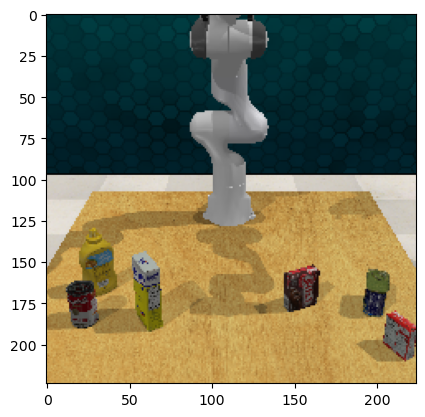

In [5]:
plt.imshow(obs.front_rgb)

In [38]:
task = env.get_task(PickDescribedObject)

agent = Agent(env.action_shape)
training_steps = 120
episode_length = 40
obs = None
for i in range(training_steps):
    # if i % episode_length == 0:
    print("Reset Episode")
    descriptions, obs = task.reset()
    print(descriptions)
    item_name = task._task.item_name
    item_coord = task._task.item.get_position()
    item_orientation = task._task.item.get_orientation()
    print(item_name)
    print(item_coord)
    print(item_orientation)
    action = agent.act(obs)
    obs, reward, terminate = task.step(action)
    print(reward)
    break


Reset Episode
['put the chocolate jello in the basket', 'pick up the chocolate jello and place in the basket', 'I want to put away the chocolate jello']
chocolate jello
[ 0.20228338 -0.09733594  0.82499516]
[ 3.14159203e+00  2.56040021e-05 -2.09441900e+00]
0.0


In [45]:
task._task.get_waypoints()[0].get_waypoint_object().get_position()

array([ 0.13631016, -0.06427181,  1.20000005])

In [46]:

print("Done")
env.shutdown()

Done
[CoppeliaSim:loadinfo]   done.
